In [0]:
import re
import random
import numpy as np
import networkx as nx
#import maxflow

from networkx.algorithms import bipartite
from random import randrange
from scipy.spatial.distance import cityblock

import matplotlib.pyplot as plt
%matplotlib inline

#Part 4: Implementing Matching Market Pricing. The goal of this exercise is to implement an algorithm for finding market-clearing and VCG prices in a bipartite matching market.  Include your code in matchingmarket.py.

##7.  Recall the procedure constructed in Theorem 8.8 of the notes to find a market equilibrium in a matching market.



##ford_fulkerson max flow code


In [0]:
#@ford_fulkerson
#Max Flow algo from assignment 2

#Implementation courtesy of the link below
#https://medium.com/100-days-of-algorithms/day-49-ford-fulkerson-e70045dafd8b
def ford_fulkerson(graph, source, sink, debug=None):
    flow, path = 0, True
    
    while path:
        path, reserve = depth_first_search(graph, source, sink)
        flow += reserve

        for v, u in zip(path, path[1:]):
            if graph.has_edge(v, u):
                graph[v][u]['flow'] += reserve
            else:
                graph[u][v]['flow'] -= reserve
    return flow

def depth_first_search(graph, source, sink):
    undirected = graph.to_undirected()
    explored = {source}
    stack = [(source, 0, dict(undirected[source]))]
    
    while stack:
        v, _, neighbours = stack[-1]
        if v == sink:
            break
        
        while neighbours:
            u, e = neighbours.popitem()
            if u not in explored:
                break
        else:
            stack.pop()
            continue
        
        in_direction = graph.has_edge(v, u)
        capacity = e['capacity']
        flow = e['flow']
        neighbours = dict(undirected[u])

        if in_direction and flow < capacity:
            stack.append((u, capacity - flow, neighbours))
            explored.add(u)
        elif not in_direction and flow:
            stack.append((u, flow, neighbours))
            explored.add(u)

    reserve = min((f for _, f, _ in stack[1:]), default=0)
    path = [v for v, _, _ in stack]
    
    return path, reserve

##draw the graph if needed
def draw_graph(layout, graph):
    plt.figure(figsize=(12, 4))
    plt.axis('off')

    nx.draw_networkx_nodes(graph, layout, node_color='steelblue', node_size=600)
    nx.draw_networkx_edges(graph, layout, edge_color='gray')
    nx.draw_networkx_labels(graph, layout, font_color='white')

    for u, v, e in graph.edges(data=True):
  
        if ('weight' in e.keys()):
          label = '{}'.format(e['weight'])
          color = 'green'
          x = layout[u][0] * .6 + layout[v][0] * .4
          y = layout[u][1] * .6 + layout[v][1] * .4
          t = plt.text(x, y, label, size=16, color=color, 
                      horizontalalignment='center', verticalalignment='center')
          
        elif ("flow" in e.keys()):
          label = '{}/{}'.format(e['flow'], e['capacity'])
          color = 'green' if e['flow'] < e['capacity'] else 'red'
          x = layout[u][0] * .6 + layout[v][0] * .4
          y = layout[u][1] * .6 + layout[v][1] * .4
          t = plt.text(x, y, label, size=16, color=color, 
                      horizontalalignment='center', verticalalignment='center')
          
    plt.show()

#(a)
The first step of this procedure involves either finding a perfect matching or a constricted set. Recall that this can be done using maximum flow. Now, using your maximum-flow implementation from assignment 2, implement an algorithm that finds either a perfect matching F or a constricted set S in a bipartite graph.

In [0]:
#perfect matching or constricted?
def match(graph, vcg=None):

  max_graph = nx.Graph.copy(graph)

  #add flow and capacity if not there
  if not nx.get_edge_attributes(max_graph,'flow'):
    nx.set_edge_attributes(max_graph, 0, 'flow')
    nx.set_edge_attributes(max_graph, 1, 'capacity')


  #add source node and sink
  max_graph.add_nodes_from('ST')

  buyers = []
  sellers = []

  #find buyers and sellers
  for edge in max_graph.edges:
    if edge[0] not in buyers:
      buyers.append(edge[0])
    if edge[1] not in sellers:
      sellers.append(edge[1])
  
  #add source edge to buyers and sink to sellers
  for node in buyers:
    max_graph.add_edge('S',node, capacity=1, flow=0)

    for node in sellers:
      max_graph.add_edge(node, 'T', capacity=1, flow=0)

  flow = ford_fulkerson(max_graph,"S", "T")
  #flow, Gnew = max_flow.fordFulkerson(max_graph, S, T)

  ##check if we have a matching market or not
  if (flow == len(buyers) == len(sellers)):
    result = 'matching'

  #need to return just constricted set if vcg
  elif vcg:
    result = []
    for node in max_graph['S']:
      if not max_graph['S'][node]['flow']:
        for x in max_graph[node]:
          #x is the item being contricted so lets return its buyers
          for con_edge in max_graph.in_edges(x):
            if con_edge not in result:
              result.append(con_edge)

  else:
    #find the constricted item nodes
    result = []
    for node in max_graph['S']:
      if not max_graph['S'][node]['flow']:
        for x in max_graph[node]:
          if x not in result:
            result.append(x)


  #create new graph showing only matching edges
  match_graph = nx.DiGraph()
  match_graph.add_nodes_from(buyers+sellers)

  for edge in graph.edges:
    if max_graph[edge[0]][edge[1]]['flow'] and 'weight' in max_graph[edge[0]][edge[1]].keys():
      match_graph.add_edge(edge[0],edge[1], weight= int(max_graph[edge[0]][edge[1]]['weight']))

    elif max_graph[edge[0]][edge[1]]['flow']:
      match_graph.add_edge(edge[0],edge[1])

  if(not result):
    result='matching'
  return result, match_graph



Example 1
Pairing Graph


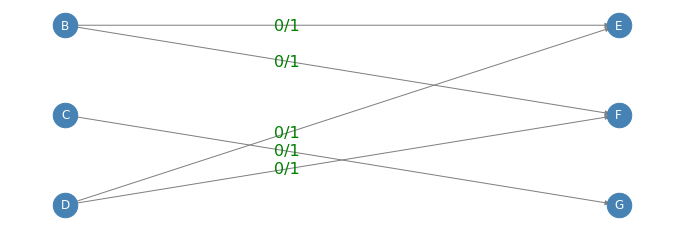

Graph is matching


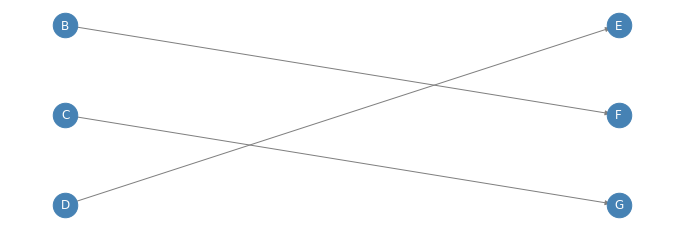





Example 2 



Pairing Graph


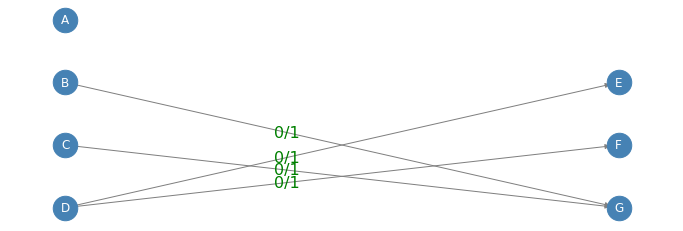

Graph is constricted ['G']


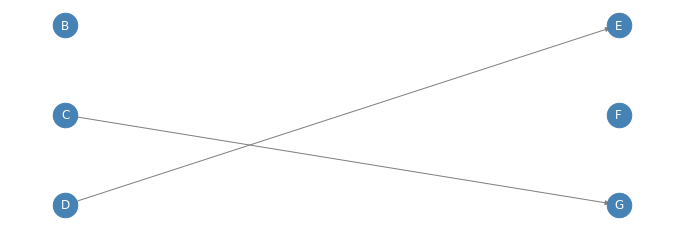

In [0]:
graph = nx.DiGraph()
graph.add_nodes_from('BCDEFG')
graph.add_edges_from([
    ('B', 'E', {'capacity': 1, 'flow': 0}),
    ('B', 'F', {'capacity': 1, 'flow': 0}),
    ('C', 'G', {'capacity': 1, 'flow': 0}),
    ('D', 'F', {'capacity': 1, 'flow': 0}),
    ('D', 'E', {'capacity': 1, 'flow': 0}),

])

layout = {
   'B': [1, 2], 'C': [1, 1], 'D': [1, 0],'A': [1, 3],
    'E': [2, 2], 'F': [2, 1], 'G': [2, 0], 'T': [3, 1], 
}

graph2 = nx.DiGraph()
graph2.add_nodes_from('ABCDEFG')
graph2.add_edges_from([
    ('B', 'G', {'capacity': 1, 'flow': 0}),
    ('C', 'G', {'capacity': 1, 'flow': 0}),
    ('D', 'F', {'capacity': 1, 'flow': 0}),
    ('D', 'E', {'capacity': 1, 'flow': 0}),
    

])


print ('Example 1')
print("Pairing Graph")
draw_graph(layout, graph)

result, graph = match(graph)
print("Graph is "+result)
draw_graph(layout, graph)

print ('\n\n\n\nExample 2 \n\n\n')

print("Pairing Graph")
draw_graph(layout, graph2)

result, graph2 = match(graph2)
print("Graph is constricted" , result)
draw_graph(layout, graph2)


#(b)
Now, given a bipartite matching frame with players, n items, and values of each player for each item, implement the full procedure to find a market equilibrium.

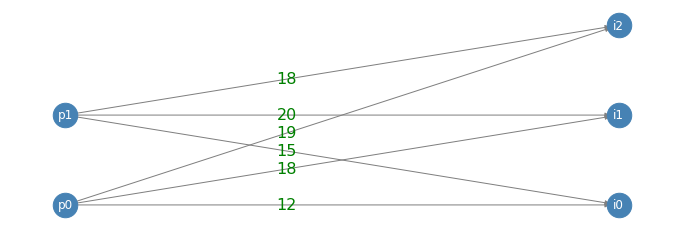

In [0]:
#create a graph with random values from each player to item
 def create_graph(players, items):
  graph = nx.DiGraph()
  edges = []
  for i in range(players):
    for j in range(items):
      edges.append(('p' + str(i),'i' + str(j),random.randint(2,20)))
  
  graph.add_weighted_edges_from(edges)

  return graph

def get_layout(players,items, uber=None):
  layout = {}

  if (uber):
    for i in range(players):
      layout['d'+str(i)] = [1,i]
    for i in range(items):
      layout['r'+str(i)] = [2,i]
    return layout

  else:
    for i in range(players):
      layout['p'+str(i)] = [1,i]
    for i in range(items):
      layout['i'+str(i)] = [2,i]
    return layout

draw_graph(get_layout(2,3),create_graph(2,3))

In [0]:
def market_clearing(graph, uber=None):
  #iterativly check if we have an equilibrium then change prices if we dont
  flag = True

  #Cant assume players and items are equal so lets find them
  buyers = []
  sellers = []

    #find buyers and sellers
  for edge in graph.edges:
    if edge[0] not in buyers:
      buyers.append(edge[0])
    if edge[1] not in sellers:
      sellers.append(edge[1])

  #set all item prices to 0
  cost = np.zeros(len(sellers))

  while(flag):
    
    #create a graph from player to favorite item and run matching market on it
    test_graph = nx.DiGraph()
    test_graph.add_nodes_from(buyers+sellers)

    for player in buyers:
      vals=[]
      for i, item in enumerate(graph[player]):
        vals.append(graph[player][item]['weight']- cost[i])

      #find the favorites (there can be ties)
      max_fav = [x for x, e in enumerate(vals) if e == max(vals)]
      for fav in max_fav:
        test_graph.add_edge(player,sellers[fav], capacity=1, flow=0, weight = graph[player][sellers[fav]]['weight']- cost[fav]) #dont be intimidated by this...

  
    #now check if we are stable
    result, matching_graph = match(test_graph)

    if result == 'matching':
      flag = False
      return matching_graph, cost
    else:
      #the result is the constricting items so we need to increase their prices!
      for node in result:
        
        cost[int(node[1:])] += 1
  
    #check if all prices are above 0 or not and shift
    if (min(cost)>0):
      print('min cost')
      cost = cost - 1 


#(c)
Submit your code along with its output on the matching market frame in figure 8.3 as well as 3 other small (10-20 node) test examples of your choice. Include the input and outputs in a file called p7.txt

Example input: figure 8.3
[('p0', 'i0', {'weight': 4}), ('p0', 'i1', {'weight': 12}), ('p0', 'i2', {'weight': 5}), ('p1', 'i0', {'weight': 7}), ('p1', 'i1', {'weight': 10}), ('p1', 'i2', {'weight': 9}), ('p2', 'i0', {'weight': 7}), ('p2', 'i1', {'weight': 7}), ('p2', 'i2', {'weight': 10})]


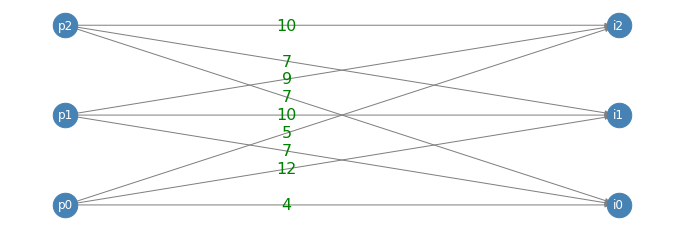

Example output equilibrium
[('p0', 'i1', {'weight': 9}), ('p1', 'i0', {'weight': 7}), ('p2', 'i2', {'weight': 8})] 
 prices (i0,i1,...in):  [0. 3. 2.] 



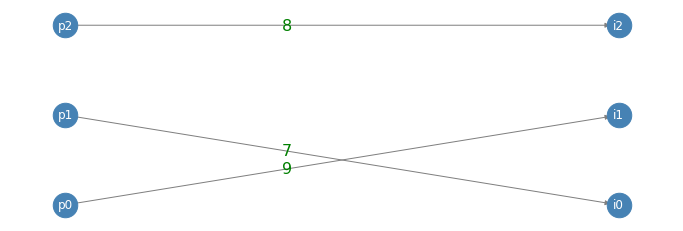

In [0]:
print('Example input: figure 8.3')


g = nx.DiGraph()
g.add_edges_from([
    ('p0', 'i0', {'weight':4}),
    ('p0', 'i1', {'weight':12}),
    ('p0', 'i2', {'weight':5}),
    ('p1', 'i0', {'weight':7}),
    ('p1', 'i1', {'weight':10}),
    ('p1', 'i2', {'weight':9}),
    ('p2', 'i0', {'weight':7}),
    ('p2', 'i1', {'weight':7}),
    ('p2', 'i2', {'weight':10}),
])
print(g.edges(data=True))
size = 3
draw_graph(get_layout(size,size),g)
g,prices = market_clearing(g)
print('Example output equilibrium')
print (g.edges(data=True),"\n prices (i0,i1,...in): ",prices,'\n')
draw_graph(get_layout(size,size),g)

Example input
[('p0', 'i0', {'weight': 20}), ('p0', 'i1', {'weight': 14}), ('p0', 'i2', {'weight': 10}), ('p1', 'i0', {'weight': 3}), ('p1', 'i1', {'weight': 14}), ('p1', 'i2', {'weight': 5}), ('p2', 'i0', {'weight': 2}), ('p2', 'i1', {'weight': 9}), ('p2', 'i2', {'weight': 12})]


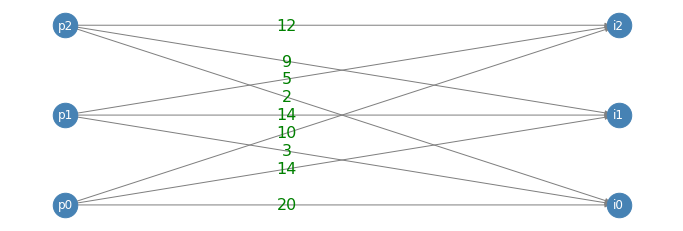

Example output equilibrium
[('p0', 'i0', {'weight': 20}), ('p1', 'i1', {'weight': 14}), ('p2', 'i2', {'weight': 12})] 
 prices (i0,i1,...in):  [0. 0. 0.] 

i0


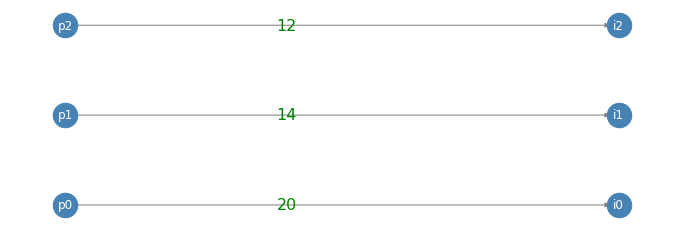

In [0]:
#three examples
print('Example input')
size = 3
g = create_graph(size,size)
print(g.edges(data=True))
draw_graph(get_layout(size,size),g)
g,prices = market_clearing(g)
print('Example output equilibrium')
print (g.edges(data=True),"\n prices (i0,i1,...in): ",prices,'\n')

best_lst = [[a, b, data['weight']] for a, b, data in g.edges('p0', data=True)]
print(best_lst[0][1])

#print("DATA", g.edges('p0', data=True)[0])
#graph_copy.edges(node, data=True)
draw_graph(get_layout(size,size),g)

Example input
[('p0', 'i0', {'weight': 18}), ('p0', 'i1', {'weight': 16}), ('p0', 'i2', {'weight': 7}), ('p0', 'i3', {'weight': 9}), ('p1', 'i0', {'weight': 13}), ('p1', 'i1', {'weight': 19}), ('p1', 'i2', {'weight': 18}), ('p1', 'i3', {'weight': 19}), ('p2', 'i0', {'weight': 16}), ('p2', 'i1', {'weight': 17}), ('p2', 'i2', {'weight': 7}), ('p2', 'i3', {'weight': 16}), ('p3', 'i0', {'weight': 20}), ('p3', 'i1', {'weight': 11}), ('p3', 'i2', {'weight': 12}), ('p3', 'i3', {'weight': 8})]


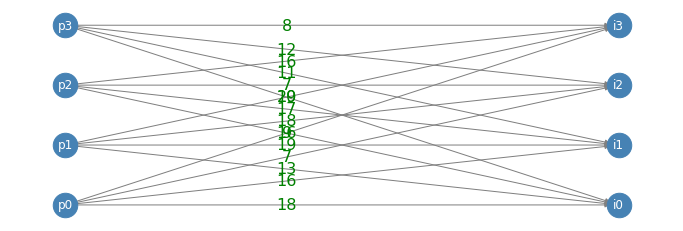

Example output equilibrium
[('p0', 'i1', {'weight': 14}), ('p1', 'i2', {'weight': 18}), ('p2', 'i3', {'weight': 15}), ('p3', 'i0', {'weight': 16})] 
 prices (i0,i1,...in):  [4. 2. 0. 1.] 



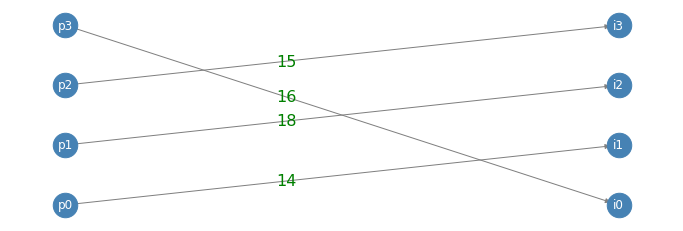

In [0]:
print('Example input')
size = 4
g = create_graph(size,size)
print(g.edges(data=True))
draw_graph(get_layout(size,size),g)
g,prices = market_clearing(g)
print('Example output equilibrium')
print (g.edges(data=True),"\n prices (i0,i1,...in): ",prices,'\n')
draw_graph(get_layout(size,size),g)

Example input
[('p0', 'i0', {'weight': 20}), ('p0', 'i1', {'weight': 10}), ('p0', 'i2', {'weight': 15}), ('p0', 'i3', {'weight': 11}), ('p0', 'i4', {'weight': 20}), ('p0', 'i5', {'weight': 5}), ('p0', 'i6', {'weight': 15}), ('p0', 'i7', {'weight': 3}), ('p0', 'i8', {'weight': 17}), ('p0', 'i9', {'weight': 7}), ('p1', 'i0', {'weight': 9}), ('p1', 'i1', {'weight': 16}), ('p1', 'i2', {'weight': 17}), ('p1', 'i3', {'weight': 19}), ('p1', 'i4', {'weight': 5}), ('p1', 'i5', {'weight': 10}), ('p1', 'i6', {'weight': 14}), ('p1', 'i7', {'weight': 6}), ('p1', 'i8', {'weight': 12}), ('p1', 'i9', {'weight': 7}), ('p2', 'i0', {'weight': 9}), ('p2', 'i1', {'weight': 10}), ('p2', 'i2', {'weight': 12}), ('p2', 'i3', {'weight': 11}), ('p2', 'i4', {'weight': 5}), ('p2', 'i5', {'weight': 13}), ('p2', 'i6', {'weight': 4}), ('p2', 'i7', {'weight': 9}), ('p2', 'i8', {'weight': 4}), ('p2', 'i9', {'weight': 2}), ('p3', 'i0', {'weight': 14}), ('p3', 'i1', {'weight': 14}), ('p3', 'i2', {'weight': 11}), ('p3', '

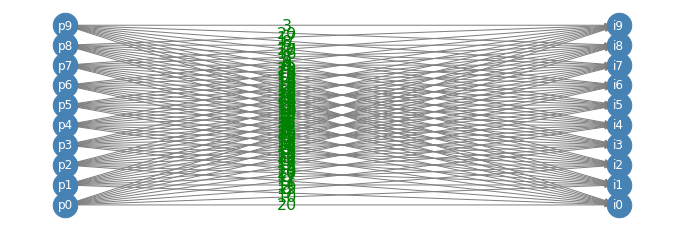

Example output equilibrium
[('p0', 'i4', {'weight': 17}), ('p1', 'i3', {'weight': 17}), ('p2', 'i7', {'weight': 9}), ('p3', 'i9', {'weight': 15}), ('p4', 'i0', {'weight': 16}), ('p5', 'i8', {'weight': 14}), ('p6', 'i1', {'weight': 16}), ('p7', 'i2', {'weight': 12}), ('p8', 'i5', {'weight': 16}), ('p9', 'i6', {'weight': 18})] 
 prices (i0,i1,...in):  [4. 1. 3. 2. 3. 4. 2. 0. 2. 5.] 



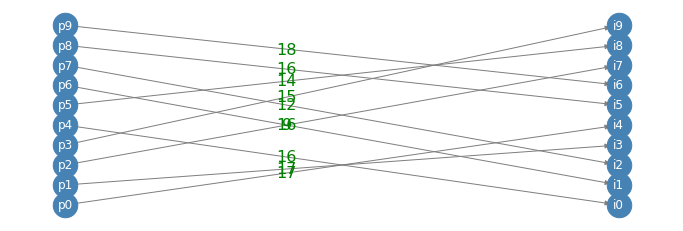

In [0]:
print('Example input')
size = 10
g = create_graph(size,size)
print(g.edges(data=True))
draw_graph(get_layout(size,size),g)
g,prices = market_clearing(g)
print('Example output equilibrium')
print (g.edges(data=True),"\n prices (i0,i1,...in): ",prices,'\n')
draw_graph(get_layout(size,size),g)

#8.  Now, given a matching market frame, we will implement VCG pricing in this frame according to the results of Theorem 10.8 in the notes.

(a)  In order to do this, we must find the socially optimal outcome.  Briefly justify that the outcome that your algorithm from the previous question finds is socially optimal (this can be done by simply stating 1-2 theorems from the notes).

Following theorem 8.7(Social optimality of market equilibria), we know that a market equilibrium optimizes social welfare, using corollary 8.6 for the proof. . 

Theorem 8.7 proof (mostly taken from the book):
Since a market equilibrium is a perfect matching in the preferred choice graph, by assumption, every buyer must receive an item that maximizes his or her own utility given the prices. Sellers’ utilities are maximized for the fixed set of prices p as well. Thus, following corollary 8.6, our equilibrium maximizes social value. 




##(b)  Finally, implement the VCG mechanism and Clarke pivot rule to construct an algorithm that produces a positive set of VCG prices in any matching market frame.


In [0]:
def social_value(values, matchings, exclude_player, buyers):
  value = 0
  for player in buyers:
    if (player != exclude_player):
      player_matching_data = [[a, b, data['weight']] for a, b, data in matchings.edges(player, data=True)]
      house_choice = player_matching_data[0][1]
      player_value_data = [[a, b, data['weight']] for a, b, data in values.edges(player, data=True)]
      
      for item in player_value_data:
        if (item[1] == house_choice):
          value = value + item[2]
          
          break
    
  return value

In [0]:
def social_value_without(values, exclude_player, buyers):
  graph_copy = nx.Graph.copy(values)
  graph_copy.remove_node(exclude_player)

  g_equilibrium, prices = market_clearing(graph_copy)

  value = 0
  for player in buyers:
    if (player != exclude_player):
      player_matching_data = [[a, b, data['weight']] for a, b, data in g_equilibrium.edges(player, data=True)]
      house_choice = player_matching_data[0][1]
      player_value_data = [[a, b, data['weight']] for a, b, data in values.edges(player, data=True)]
     
      for item in player_value_data:
        if (item[1] == house_choice):
          value = value + item[2]
          break

  return value

In [0]:
def vcg(input_graph, buyers):
  g_equilibrium, prices = market_clearing(input_graph)
  
  pricings = list()
  for player in buyers:
    w = social_value(input_graph, g_equilibrium, player, buyers)
    wo = social_value_without(input_graph, player, buyers)
    externality = wo - w
    print("Player {}'s externality: {}".format(player, externality))
    pricings.append(externality)
    
  return pricings

##(c)  Submit your code along with its output on the matching market frame in figure 8.3 as well as 3 other small (10-20 node) test examples of your choice.  Include the input and outputs in a file called p8.txt

In [0]:
graph_102 = nx.DiGraph()

graph_102.add_edges_from([
    ('p0', 'i0', {'weight' : 4}),
    ('p0', 'i1', {'weight' : 12}),
    ('p0', 'i2', {'weight' : 5}),
    ('p1', 'i0', {'weight' : 7}),
    ('p1', 'i1', {'weight' : 10}),
    ('p1', 'i2', {'weight' : 9}),
    ('p2', 'i0', {'weight' : 7}),
    ('p2', 'i1', {'weight' : 7}),
    ('p2', 'i2', {'weight' : 10}),
])

buyers = list()
sellers = list()

#find buyers and sellers
for edge in graph_102.edges:
  if (edge[0] not in buyers):
    buyers.append(edge[0])
  if (edge[1] not in sellers):
    sellers.append(edge[1])

print('example figure 8.3')
print('input:', graph_102.edges(data=True))
res = vcg(graph_102, buyers)
res

example figure 8.3
input: [('p0', 'i0', {'weight': 4}), ('p0', 'i1', {'weight': 12}), ('p0', 'i2', {'weight': 5}), ('p1', 'i0', {'weight': 7}), ('p1', 'i1', {'weight': 10}), ('p1', 'i2', {'weight': 9}), ('p2', 'i0', {'weight': 7}), ('p2', 'i1', {'weight': 7}), ('p2', 'i2', {'weight': 10})]
Player p0's externality: 3
Player p1's externality: 0
Player p2's externality: 2


[3, 0, 2]

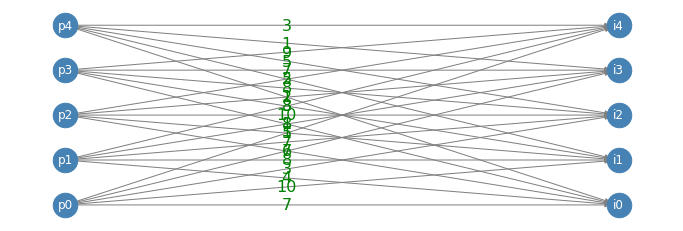

input:  [('p0', 'i0', {'weight': 7}), ('p0', 'i1', {'weight': 10}), ('p0', 'i2', {'weight': 3}), ('p0', 'i3', {'weight': 6}), ('p0', 'i4', {'weight': 1}), ('p1', 'i0', {'weight': 4}), ('p1', 'i1', {'weight': 8}), ('p1', 'i2', {'weight': 7}), ('p1', 'i3', {'weight': 1}), ('p1', 'i4', {'weight': 8}), ('p2', 'i0', {'weight': 7}), ('p2', 'i1', {'weight': 5}), ('p2', 'i2', {'weight': 10}), ('p2', 'i3', {'weight': 2}), ('p2', 'i4', {'weight': 2}), ('p3', 'i0', {'weight': 8}), ('p3', 'i1', {'weight': 3}), ('p3', 'i2', {'weight': 8}), ('p3', 'i3', {'weight': 7}), ('p3', 'i4', {'weight': 9}), ('p4', 'i0', {'weight': 1}), ('p4', 'i1', {'weight': 5}), ('p4', 'i2', {'weight': 5}), ('p4', 'i3', {'weight': 1}), ('p4', 'i4', {'weight': 3})]
Player p0's externality: 0
Player p1's externality: 2
Player p2's externality: 4
Player p3's externality: 1
Player p4's externality: 4


[0, 2, 4, 1, 4]

In [0]:
graph_test_2 = nx.DiGraph()

graph_test_2.add_edges_from([
    ('p0', 'i0', { 'weight' : random.randint(1, 10)}),
    ('p0', 'i1', {'weight' : random.randint(1, 10)}),
    ('p0', 'i2', {'weight' : random.randint(1, 10)}),
    ('p0', 'i3', {'weight' : random.randint(1, 10)}),
    ('p0', 'i4', {'weight' : random.randint(1, 10)}),

    ('p1', 'i0', {'weight' : random.randint(1, 10)}),
    ('p1', 'i1', {'weight' : random.randint(1, 10)}),
    ('p1', 'i2', {'weight' : random.randint(1, 10)}),
    ('p1', 'i3', {'weight' : random.randint(1, 10)}),
    ('p1', 'i4', {'weight' : random.randint(1, 10)}),

    ('p2', 'i0', {'weight' : random.randint(1, 10)}),
    ('p2', 'i1', {'weight' : random.randint(1, 10)}),
    ('p2', 'i2', {'weight' : random.randint(1, 10)}),
    ('p2', 'i3', {'weight' : random.randint(1, 10)}),
    ('p2', 'i4', {'weight' : random.randint(1, 10)}),

    ('p3', 'i0', {'weight' : random.randint(1, 10)}),
    ('p3', 'i1', {'weight' : random.randint(1, 10)}),
    ('p3', 'i2', {'weight' : random.randint(1, 10)}),
    ('p3', 'i3', {'weight' : random.randint(1, 10)}),
    ('p3', 'i4', {'weight' : random.randint(1, 10)}),

    ('p4', 'i0', {'weight' : random.randint(1, 5)}),
    ('p4', 'i1', {'weight' : random.randint(1, 5)}),
    ('p4', 'i2', {'weight' : random.randint(1, 5)}),
    ('p4', 'i3', {'weight' : random.randint(1, 5)}),
    ('p4', 'i4', {'weight' : random.randint(1, 5)}),
])

size=5
draw_graph(get_layout(size,size), graph_test_2)

buyers_two = list()
sellers_two = list()

#find buyers and sellers
for edge in graph_test_2.edges:
  if (edge[0] not in buyers_two):
    buyers_two.append(edge[0])
  if (edge[1] not in sellers_two):
    sellers_two.append(edge[1])

print('input: ',graph_test_2.edges(data=True))
res = vcg(graph_test_2, buyers_two)
res

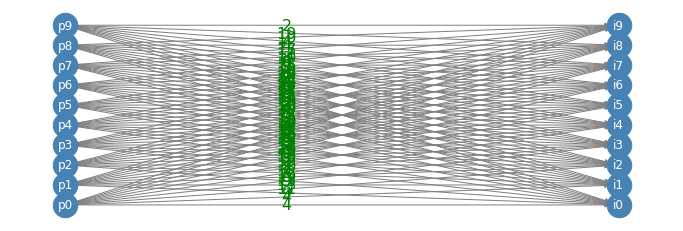

input:  [('p0', 'i0', {'weight': 4}), ('p0', 'i1', {'weight': 4}), ('p0', 'i2', {'weight': 11}), ('p0', 'i3', {'weight': 13}), ('p0', 'i4', {'weight': 12}), ('p0', 'i5', {'weight': 16}), ('p0', 'i6', {'weight': 10}), ('p0', 'i7', {'weight': 3}), ('p0', 'i8', {'weight': 15}), ('p0', 'i9', {'weight': 18}), ('p1', 'i0', {'weight': 9}), ('p1', 'i1', {'weight': 13}), ('p1', 'i2', {'weight': 19}), ('p1', 'i3', {'weight': 2}), ('p1', 'i4', {'weight': 2}), ('p1', 'i5', {'weight': 9}), ('p1', 'i6', {'weight': 11}), ('p1', 'i7', {'weight': 9}), ('p1', 'i8', {'weight': 9}), ('p1', 'i9', {'weight': 13}), ('p2', 'i0', {'weight': 9}), ('p2', 'i1', {'weight': 8}), ('p2', 'i2', {'weight': 2}), ('p2', 'i3', {'weight': 13}), ('p2', 'i4', {'weight': 20}), ('p2', 'i5', {'weight': 9}), ('p2', 'i6', {'weight': 2}), ('p2', 'i7', {'weight': 2}), ('p2', 'i8', {'weight': 9}), ('p2', 'i9', {'weight': 4}), ('p3', 'i0', {'weight': 7}), ('p3', 'i1', {'weight': 15}), ('p3', 'i2', {'weight': 6}), ('p3', 'i3', {'weigh

[6, 5, 8, 5, 6, 7, 3, 0, 8, 7]

In [0]:
graph_test_3 = create_graph(10,10)
size=10
draw_graph(get_layout(size,size), graph_test_3)

buyers_two = list()
sellers_two = list()

#find buyers and sellers
for edge in graph_test_3.edges:
  if (edge[0] not in buyers_two):
    buyers_two.append(edge[0])
  if (edge[1] not in sellers_two):
    sellers_two.append(edge[1])

print('input: ',graph_test_3.edges(data=True))
res = vcg(graph_test_3, buyers_two)
res

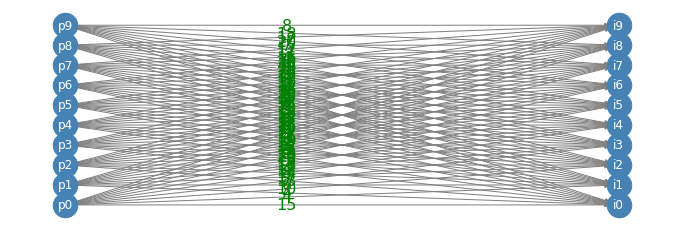

input:  [('p0', 'i0', {'weight': 15}), ('p0', 'i1', {'weight': 4}), ('p0', 'i2', {'weight': 10}), ('p0', 'i3', {'weight': 7}), ('p0', 'i4', {'weight': 8}), ('p0', 'i5', {'weight': 17}), ('p0', 'i6', {'weight': 20}), ('p0', 'i7', {'weight': 3}), ('p0', 'i8', {'weight': 10}), ('p0', 'i9', {'weight': 17}), ('p1', 'i0', {'weight': 4}), ('p1', 'i1', {'weight': 6}), ('p1', 'i2', {'weight': 17}), ('p1', 'i3', {'weight': 4}), ('p1', 'i4', {'weight': 17}), ('p1', 'i5', {'weight': 19}), ('p1', 'i6', {'weight': 8}), ('p1', 'i7', {'weight': 11}), ('p1', 'i8', {'weight': 6}), ('p1', 'i9', {'weight': 9}), ('p2', 'i0', {'weight': 13}), ('p2', 'i1', {'weight': 14}), ('p2', 'i2', {'weight': 18}), ('p2', 'i3', {'weight': 19}), ('p2', 'i4', {'weight': 17}), ('p2', 'i5', {'weight': 4}), ('p2', 'i6', {'weight': 9}), ('p2', 'i7', {'weight': 13}), ('p2', 'i8', {'weight': 14}), ('p2', 'i9', {'weight': 13}), ('p3', 'i0', {'weight': 17}), ('p3', 'i1', {'weight': 5}), ('p3', 'i2', {'weight': 14}), ('p3', 'i3', {

[0, 2, 0, 0, 1, 1, 0, 0, 0, 0]

In [0]:
graph_test_4 = create_graph(10,10)
size=10
draw_graph(get_layout(size,size), graph_test_4)

buyers_two = list()
sellers_two = list()

#find buyers and sellers
for edge in graph_test_4.edges:
  if (edge[0] not in buyers_two):
    buyers_two.append(edge[0])
  if (edge[1] not in sellers_two):
    sellers_two.append(edge[1])

print('input: ',graph_test_4.edges(data=True))
res = vcg(graph_test_4, buyers_two)
res

#9.  Now simulate your VCG pricing algorithm in the following context.

(a)  First, construct a graph of 20 buyers and 20 items.  Assume that “item” i is actually a bundle of identical goods.  Now assign each player a random value per good (say, from1 to 50;  ties can be allowed).  You shouldn’t need to do any additional work on your algorithm to do this, instead just set each buyer’s value per bundle appropriately.  How Should we set these values?

(b)  Having  set  the  values  accordingly,  run  your  VCG  pricing  algorithm  and  turn  in  the results in a file called p9.txt.  Explain why the results you obtained make sense in the context above.


In [0]:
buyer_vals = []
bundle_size = []

for x in range(20):
  buyer_vals.append(random.randint(1,50))
  bundle_size.append(random.randint(1,30))

buyer_vals.sort()
bundle_size.sort()

buyer_vals.reverse()
bundle_size.reverse()

bundle_size=np.arange(20)+1
bundle_size = np.flip(bundle_size,axis=0)
print(buyer_vals)
print(bundle_size)

[49, 47, 38, 35, 32, 32, 32, 32, 29, 25, 22, 21, 15, 14, 7, 7, 3, 2, 2, 2]
[20 19 18 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3  2  1]


In [0]:
market = []

for buyer in buyer_vals: 
  buyer_bundle_edge = []
  for bundle in bundle_size: 
    buyer_bundle_edge.append(buyer * bundle)
  market.append(buyer_bundle_edge)

vcg_graph = nx.DiGraph()
tmp = []
dim =20
for i in range(dim):
  for j in range(dim):
    tmp.append(['p'+str(i), 'i'+str(j), {'weight' : market[i][j]}])
vcg_graph.add_edges_from(tmp)


In [0]:
buyers_two = list()
sellers_two = list()

#find buyers and sellers
for edge in vcg_graph.edges:
  if (edge[0] not in buyers_two):
    buyers_two.append(edge[0])
  if (edge[1] not in sellers_two):
    sellers_two.append(edge[1])
print(market)
print(vcg_graph.edges(data=True))

res = vcg(vcg_graph, buyers_two)
res

[[980, 931, 882, 833, 784, 735, 686, 637, 588, 539, 490, 441, 392, 343, 294, 245, 196, 147, 98, 49], [940, 893, 846, 799, 752, 705, 658, 611, 564, 517, 470, 423, 376, 329, 282, 235, 188, 141, 94, 47], [760, 722, 684, 646, 608, 570, 532, 494, 456, 418, 380, 342, 304, 266, 228, 190, 152, 114, 76, 38], [700, 665, 630, 595, 560, 525, 490, 455, 420, 385, 350, 315, 280, 245, 210, 175, 140, 105, 70, 35], [640, 608, 576, 544, 512, 480, 448, 416, 384, 352, 320, 288, 256, 224, 192, 160, 128, 96, 64, 32], [640, 608, 576, 544, 512, 480, 448, 416, 384, 352, 320, 288, 256, 224, 192, 160, 128, 96, 64, 32], [640, 608, 576, 544, 512, 480, 448, 416, 384, 352, 320, 288, 256, 224, 192, 160, 128, 96, 64, 32], [640, 608, 576, 544, 512, 480, 448, 416, 384, 352, 320, 288, 256, 224, 192, 160, 128, 96, 64, 32], [580, 551, 522, 493, 464, 435, 406, 377, 348, 319, 290, 261, 232, 203, 174, 145, 116, 87, 58, 29], [500, 475, 450, 425, 400, 375, 350, 325, 300, 275, 250, 225, 200, 175, 150, 125, 100, 75, 50, 25], [440,

[397,
 350,
 312,
 277,
 149,
 181,
 213,
 245,
 120,
 95,
 73,
 52,
 37,
 23,
 9,
 16,
 6,
 0,
 2,
 4]

#*Bonus Question 2.(Please note that each part of this question is intended to be harder than the previous parts; each part will be graded separately, and you are not required to do the whole thing.)

(a)  Implement an algorithm for GSP pricing in a matching-market context.  Compare yourVCG prices from the previous question to the GSP prices when run in the same contexts(with the same  randomness).  Also,  try  to find and characterize some  contexts whereVCG  and  GSP  prices  are  similar,  and  where  they  are  wildly  different.   Include  a  file called bonus-2a.txt displaying input and output on a few examples.

(b)  GSP isn’t truthful, so interesting things might happen if we run BRD on a GSP matching market auction (where a player’s “strategy” is their valuation report).  Implement an algorithm that picks a random starting point and runs BRD to attempt to find a GPS equilibrium state.  What happens?  Does BRD converge; if so, how quickly?  Include a file called bonus-2b.txt displaying input and output on a few examples.

(c)(Very  difficult.)Either prove that BRD will converge in a GSP context, or disprove it by counterexample.


#Part 5: Exchange Networks for UberWe will construct a simplified market scenario for a ridesharing app like Uber.  Our world will consist  of  ann×ngrid  (think  of  100×100  as  a  test  example),  and  there  will  be  two  types  of participants, riders and drivers.

•A rider R is specified by a current location (x0, y0)∈[n]×[n], a desired destination (x1, y1)∈[n]×[n], and a value for reaching that destination.

•A driverDis specified by a current location (x0, y0)∈[n]×[n].

We define the cost of a matching between a riderRand a driverD,c(R, D), to be the distance from the driver to the rider and then to the destination (measured via manhattan distance, so the distance from (0,0) to (5,2) is 7).



##10.  Encode the above example as an exchange network and implement it in ‘uber.py.’  Namely,define a graphG= (V, E) where the vertices are the riders and drivers and there is an edge between every rider and driver.  What value should we associate with each edge in the graph?Justify your answer.


The edge should be the value - cost. Because that is the 'potential utility' of a partnership between rider and driver. 

Following chapter 8.1: 
Given a set of players (buyers) X = [n] = {1, . . . , n} and a set of n items Y :
*  we associate with each player (buyer) i ∈ X, a valuation function vi
:Y → N. For each y ∈ Y , vi(y) determines i’s value for item y.
*   we associate with each item y ∈ Y , a price p(y) ∈ N.
* a buyer i who receives an item y gets utility
vi(y) − p(y). 

In [0]:
# this function makes the 100 by 100 grid and adds drivers/riders with a val
def getGraph(dim,riders,drivers, val):
  r = []
  d = []
  edges = []

  #populate riders each element is [location,destination,value]
  for i in range(riders):
    #if val is an array we will use the values based on the array values otherwise lets do random values in range

    if (type(val) == int):
      v = val
    r.append([[randrange(dim),randrange(dim)],[randrange(dim),randrange(dim)],v])

  
  #populate drivers each element is [destination]
  for i in range(drivers):
    d.append([randrange(dim),randrange(dim)])
  


  #now make edge list with edge value (value-cost) each element is [driver node, rider node, value-cost]
  for i in range(drivers):
    for j in range(riders):
      
      edge_val = r[j][2] - cityblock(d[i],r[j][0])
      edges.append([i,j,edge_val])

  ##add dummy variable add riders if more drivers
  if (drivers>riders):
    #add riders
    for i in range(drivers-riders):
      r.append([[0,0],[100,100],-9999999])
      for j in range(drivers):
        edges.append([j,i+riders,-1])




  return np.asarray(r),np.asarray(d), np.asarray(edges)

##11.  Using your algorithm for matching markets above, implement a procedure (in uber.py) that computes a stable outcome in this context.  Note that there may not be the same number of riders and drivers.

In [0]:
#use this to show the grid
def showGrid(drivers,riders):
  plt.grid()
  plt.plot(drivers[:,0], drivers[:,1], 'o')
  plt.plot([i[0] for i in riders], [i[1] for i in riders], 'o')

  for i,d in enumerate(drivers):
    plt.text(d[0],d[1],'d'+str(i),horizontalalignment='right')

  for i,r in enumerate(riders):
    plt.text(r[0],r[1],'r'+str(i),horizontalalignment='right')
  
  plt.show()

In [0]:

#lets make a bipartite graph now for uber
def make_uber_graph(edges):
  graph = nx.DiGraph()
  for edge in edges:
    graph.add_edge('d'+ str(edge[0]), 'r'+ str(edge[1]), weight = edge[2])

  return graph

def show_uber(r,d):

  riders, drivers, edges = getGraph(100,r,d,200)

  if (d>r):
    r=d

  uber_graph = make_uber_graph(edges)
  print(uber_graph.edges(data=True))
  draw_graph(get_layout(d,r,True),uber_graph)


  g,not_used = market_clearing(uber_graph)

  #remove dummy riders and their prices
  
  remove=[]
  prices=[]
  discounts = []
  for edge in g.edges(data=True):
    #if negative remove the dummy
    if edge[2]['weight'] < 0: 
     
      remove.append(edge[1])
    #prices werent working so lets update here
    else:
      #not using this yet but might need it
      new_weight = edge[2]['weight']
      old_weight = uber_graph[edge[0]][edge[1]]['weight']
      prices.append(new_weight)
      discounts.append(old_weight - new_weight)


  for node in remove:
    g.remove_node(node)
      
    
  print("Driver discounts [d0,d1,...dn]: ",discounts)
  print("Drivers recieve [d0,d1,...dn]: ",prices)
  draw_graph(get_layout(d,r, True), g)
  showGrid(drivers, riders[:,0])
  



###(a)  Construct at least two test examples with at least 5 riders and drivers.  Discuss what the stable outcome is for your chosen examples.  Explain what your results say about how much the riders are charged and how much the drivers are profiting.

[('d0', 'r0', {'weight': 123}), ('d0', 'r1', {'weight': 108}), ('d0', 'r2', {'weight': 141}), ('d0', 'r3', {'weight': 158}), ('d0', 'r4', {'weight': 146}), ('d1', 'r0', {'weight': 110}), ('d1', 'r1', {'weight': 151}), ('d1', 'r2', {'weight': 134}), ('d1', 'r3', {'weight': 113}), ('d1', 'r4', {'weight': 95}), ('d2', 'r0', {'weight': 94}), ('d2', 'r1', {'weight': 135}), ('d2', 'r2', {'weight': 146}), ('d2', 'r3', {'weight': 125}), ('d2', 'r4', {'weight': 107}), ('d3', 'r0', {'weight': 134}), ('d3', 'r1', {'weight': 119}), ('d3', 'r2', {'weight': 174}), ('d3', 'r3', {'weight': 175}), ('d3', 'r4', {'weight': 157}), ('d4', 'r0', {'weight': 169}), ('d4', 'r1', {'weight': 164}), ('d4', 'r2', {'weight': 151}), ('d4', 'r3', {'weight': 130}), ('d4', 'r4', {'weight': 112})]


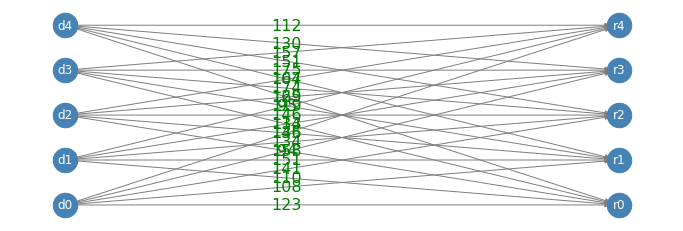

Driver discounts [d0,d1,...dn]:  [0, 0, 11, 12, 0]
Drivers recieve [d0,d1,...dn]:  [146, 151, 135, 163, 169]


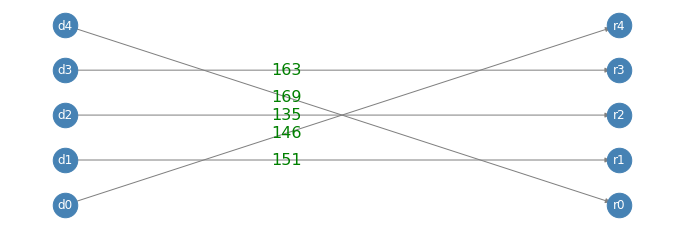

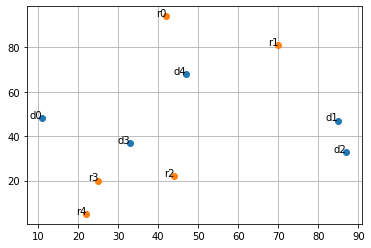

In [0]:
show_uber(r=5,d=5)

[('d0', 'r0', {'weight': 161}), ('d0', 'r1', {'weight': 109}), ('d0', 'r2', {'weight': 68}), ('d0', 'r3', {'weight': 157}), ('d0', 'r4', {'weight': 171}), ('d1', 'r0', {'weight': 142}), ('d1', 'r1', {'weight': 186}), ('d1', 'r2', {'weight': 165}), ('d1', 'r3', {'weight': 144}), ('d1', 'r4', {'weight': 114}), ('d2', 'r0', {'weight': 175}), ('d2', 'r1', {'weight': 135}), ('d2', 'r2', {'weight': 94}), ('d2', 'r3', {'weight': 153}), ('d2', 'r4', {'weight': 167}), ('d3', 'r0', {'weight': 150}), ('d3', 'r1', {'weight': 164}), ('d3', 'r2', {'weight': 123}), ('d3', 'r3', {'weight': 172}), ('d3', 'r4', {'weight': 156}), ('d4', 'r0', {'weight': 117}), ('d4', 'r1', {'weight': 131}), ('d4', 'r2', {'weight': 130}), ('d4', 'r3', {'weight': 139}), ('d4', 'r4', {'weight': 125})]


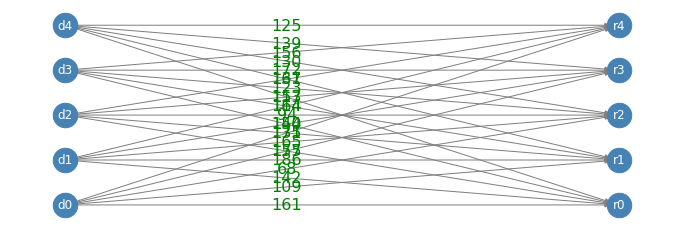

Driver discounts [d0,d1,...dn]:  [0, 1, 0, 9, 0]
Drivers recieve [d0,d1,...dn]:  [171, 185, 175, 163, 130]


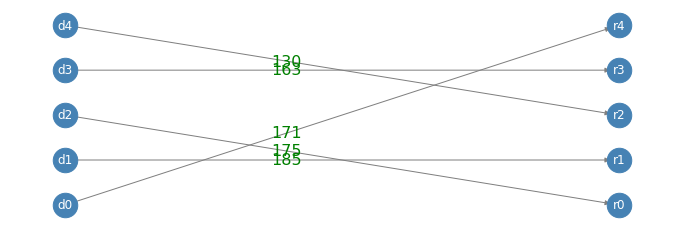

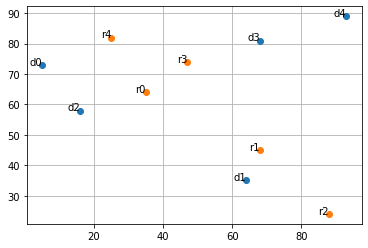

In [0]:
show_uber(r=5,d=5)

###(b)  Implement a procedure that on a 100×100 grid (1) generates riders (located randomly in the grid) each with a value of 100,ddrivers (also located randomly in the grid) and(2) computes a stable outcome given this context.  Run your procedure many times when r=d (say, 10 each), r is much less than d (say, 5 vs. 20), and when r is much greater than d (say,  20  vs.  5).   Discuss  your  results  in  detail.   Specifically,  discuss  prices  and profits for different ranges of r and d.

results with 10 riders and 10 drivers
[('d0', 'r0', {'weight': 177}), ('d0', 'r1', {'weight': 172}), ('d0', 'r2', {'weight': 151}), ('d0', 'r3', {'weight': 103}), ('d0', 'r4', {'weight': 163}), ('d0', 'r5', {'weight': 181}), ('d0', 'r6', {'weight': 137}), ('d0', 'r7', {'weight': 125}), ('d0', 'r8', {'weight': 143}), ('d0', 'r9', {'weight': 129}), ('d1', 'r0', {'weight': 54}), ('d1', 'r1', {'weight': 47}), ('d1', 'r2', {'weight': 124}), ('d1', 'r3', {'weight': 172}), ('d1', 'r4', {'weight': 112}), ('d1', 'r5', {'weight': 90}), ('d1', 'r6', {'weight': 138}), ('d1', 'r7', {'weight': 150}), ('d1', 'r8', {'weight': 112}), ('d1', 'r9', {'weight': 72}), ('d2', 'r0', {'weight': 159}), ('d2', 'r1', {'weight': 158}), ('d2', 'r2', {'weight': 163}), ('d2', 'r3', {'weight': 115}), ('d2', 'r4', {'weight': 175}), ('d2', 'r5', {'weight': 163}), ('d2', 'r6', {'weight': 119}), ('d2', 'r7', {'weight': 135}), ('d2', 'r8', {'weight': 161}), ('d2', 'r9', {'weight': 111}), ('d3', 'r0', {'weight': 114}), ('d3

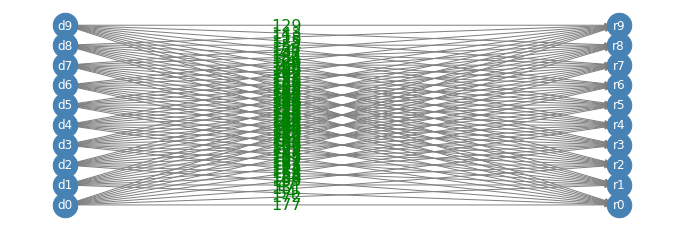

Driver discounts [d0,d1,...dn]:  [29, 12, 46, 34, 0, 38, 0, 32, 50, 34]
Drivers recieve [d0,d1,...dn]:  [143, 138, 129, 134, 146, 151, 140, 152, 132, 143]


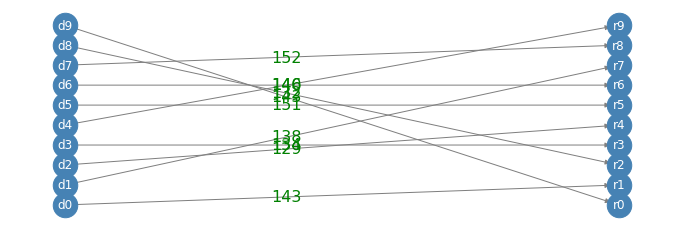

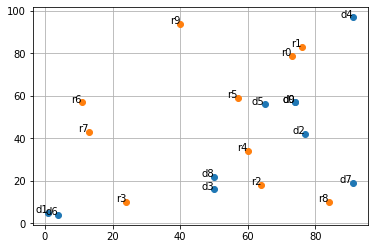

In [0]:
##we changed the value to 200 so that we could have our dummy values be a negative number, when 100 was the val real riders could have negative weights
print ("results with 10 riders and 10 drivers")
show_uber(r=10,d=10)

results with 5 riders and 20 drivers
[('d0', 'r0', {'weight': 138}), ('d0', 'r1', {'weight': 131}), ('d0', 'r2', {'weight': 104}), ('d0', 'r3', {'weight': 110}), ('d0', 'r4', {'weight': 163}), ('d0', 'r5', {'weight': -1}), ('d0', 'r6', {'weight': -1}), ('d0', 'r7', {'weight': -1}), ('d0', 'r8', {'weight': -1}), ('d0', 'r9', {'weight': -1}), ('d0', 'r10', {'weight': -1}), ('d0', 'r11', {'weight': -1}), ('d0', 'r12', {'weight': -1}), ('d0', 'r13', {'weight': -1}), ('d0', 'r14', {'weight': -1}), ('d0', 'r15', {'weight': -1}), ('d0', 'r16', {'weight': -1}), ('d0', 'r17', {'weight': -1}), ('d0', 'r18', {'weight': -1}), ('d0', 'r19', {'weight': -1}), ('d1', 'r0', {'weight': 157}), ('d1', 'r1', {'weight': 150}), ('d1', 'r2', {'weight': 155}), ('d1', 'r3', {'weight': 173}), ('d1', 'r4', {'weight': 138}), ('d1', 'r5', {'weight': -1}), ('d1', 'r6', {'weight': -1}), ('d1', 'r7', {'weight': -1}), ('d1', 'r8', {'weight': -1}), ('d1', 'r9', {'weight': -1}), ('d1', 'r10', {'weight': -1}), ('d1', 'r11

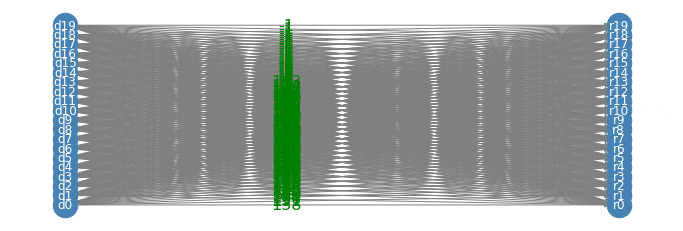

Driver discounts [d0,d1,...dn]:  [161, 157, 184, 160, 175]
Drivers recieve [d0,d1,...dn]:  [34, 32, 14, 3, 2]


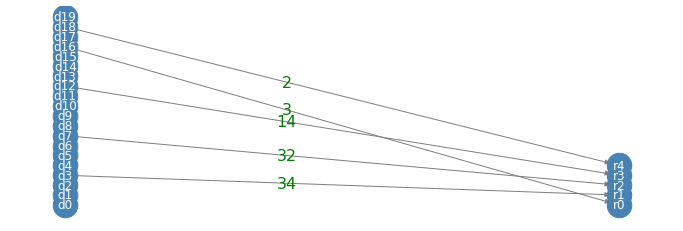

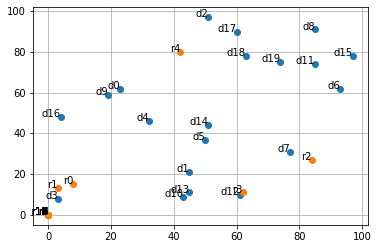

In [0]:
print ("results with 5 riders and 20 drivers")
show_uber(r=5,d=20)

results with 20 riders and 5 drivers
[('d0', 'r0', {'weight': 187}), ('d0', 'r1', {'weight': 140}), ('d0', 'r2', {'weight': 95}), ('d0', 'r3', {'weight': 122}), ('d0', 'r4', {'weight': 190}), ('d0', 'r5', {'weight': 146}), ('d0', 'r6', {'weight': 113}), ('d0', 'r7', {'weight': 172}), ('d0', 'r8', {'weight': 182}), ('d0', 'r9', {'weight': 147}), ('d0', 'r10', {'weight': 125}), ('d0', 'r11', {'weight': 113}), ('d0', 'r12', {'weight': 160}), ('d0', 'r13', {'weight': 189}), ('d0', 'r14', {'weight': 140}), ('d0', 'r15', {'weight': 136}), ('d0', 'r16', {'weight': 86}), ('d0', 'r17', {'weight': 122}), ('d0', 'r18', {'weight': 37}), ('d0', 'r19', {'weight': 160}), ('d1', 'r0', {'weight': 123}), ('d1', 'r1', {'weight': 184}), ('d1', 'r2', {'weight': 159}), ('d1', 'r3', {'weight': 186}), ('d1', 'r4', {'weight': 134}), ('d1', 'r5', {'weight': 100}), ('d1', 'r6', {'weight': 177}), ('d1', 'r7', {'weight': 132}), ('d1', 'r8', {'weight': 118}), ('d1', 'r9', {'weight': 169}), ('d1', 'r10', {'weight': 

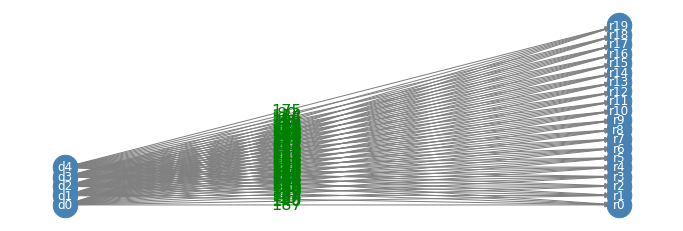

Driver discounts [d0,d1,...dn]:  [0, 0, 0, 0, 0]
Drivers recieve [d0,d1,...dn]:  [190, 189, 189, 191, 191]


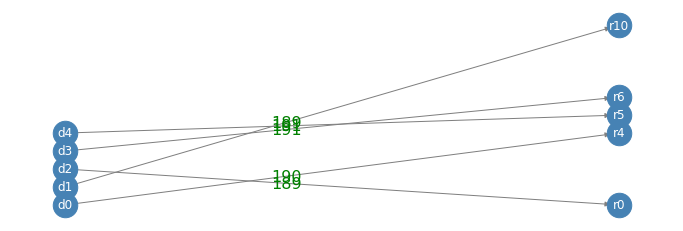

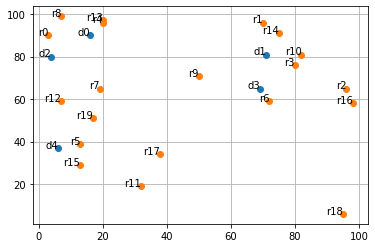

In [0]:
print ("results with 20 riders and 5 drivers")
show_uber(r=20,d=5)

##12.  With  ridesharing  apps,  drivers  often  have  preferences  for  where  they  want  to  drive.   For Example, they know they are more likely to get a high value ride from the airport.  Describe in a few sentences how you you could modify the existing setup to include driver’s preferences.


There are a few scenarios where drivers will have a preference for where they want to drive. One example would be when a driver is 'heading home' and wants to pick a passenger who is going in the direction of their home. In this case, we could change the cost function to the distance from the rider dropoff to the uber driver's home. The logic here is the further away the dropoff to the driver's home, the bigger the cost, and the closer the dropoff to the driver's home, the smaller the cost. 3

Another scenario is where specific areas (e.g. airports) are more likely to get a higher valuation ride. In this case, we could specify a quadrant in our map, where if riders are located in that quadrant, their valuation function is increased by a multiplier. 